In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# Make plots inline
%matplotlib inline

In [2]:
def function(x):
    N = x.size()
    return torch.sin(x * (2 * math.pi)) + torch.randn(N) * 0.1
X_train = torch.linspace(0, 1, 40)
Y_train = function(X_train)
X_test = torch.linspace(1, 2, 20)
Y_test  = function(X_test)
X_plot = X_train.detach().clone()
Y_plot = Y_train.detach().clone()

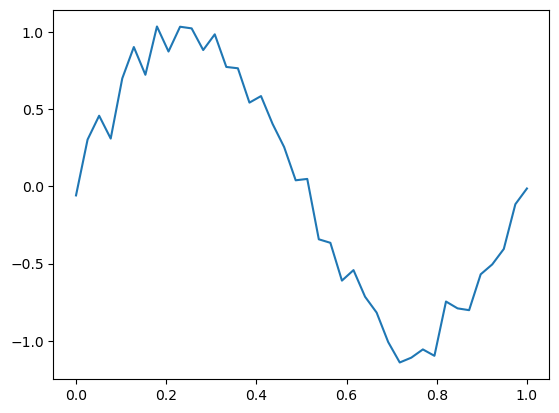

In [3]:
plt.plot(X_train,Y_train)

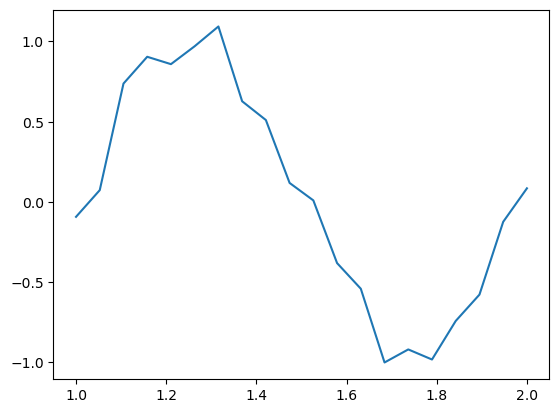

In [4]:
plt.plot(X_test,Y_test)

In [26]:
## Define the Model
test_inducing = torch.linspace(0, 0.1, 5)
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, PeriodicKernel, CosineKernel, MaternKernel, linear_kernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(PeriodicKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=test_inducing, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [27]:
#likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(len(X_train)) * 1, learn_additional_noise=False)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, Y_train, likelihood)

In [28]:
training_iterations = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
np.random.seed(10)
inducing = torch.ones([training_iterations,len(test_inducing),2])

def train():
    for i in range(training_iterations):
        inducing[i,:,0] = test_inducing
        inducing[i,:,1] = torch.zeros_like(test_inducing)
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, Y_train)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        torch.cuda.empty_cache()

# See dkl_mnist.ipynb for explanation of this flag
%time train()

Iter 1/1000 - Loss: 1.318
Iter 2/1000 - Loss: 1.301
Iter 3/1000 - Loss: 1.284
Iter 4/1000 - Loss: 1.267
Iter 5/1000 - Loss: 1.249
Iter 6/1000 - Loss: 1.230
Iter 7/1000 - Loss: 1.212
Iter 8/1000 - Loss: 1.194
Iter 9/1000 - Loss: 1.177
Iter 10/1000 - Loss: 1.162
Iter 11/1000 - Loss: 1.149
Iter 12/1000 - Loss: 1.138
Iter 13/1000 - Loss: 1.128
Iter 14/1000 - Loss: 1.119
Iter 15/1000 - Loss: 1.109
Iter 16/1000 - Loss: 1.098
Iter 17/1000 - Loss: 1.087
Iter 18/1000 - Loss: 1.075
Iter 19/1000 - Loss: 1.063
Iter 20/1000 - Loss: 1.051
Iter 21/1000 - Loss: 1.038
Iter 22/1000 - Loss: 1.027
Iter 23/1000 - Loss: 1.015
Iter 24/1000 - Loss: 1.004
Iter 25/1000 - Loss: 0.993
Iter 26/1000 - Loss: 0.982
Iter 27/1000 - Loss: 0.971
Iter 28/1000 - Loss: 0.960
Iter 29/1000 - Loss: 0.950
Iter 30/1000 - Loss: 0.939
Iter 31/1000 - Loss: 0.928
Iter 32/1000 - Loss: 0.917
Iter 33/1000 - Loss: 0.906
Iter 34/1000 - Loss: 0.895
Iter 35/1000 - Loss: 0.884
Iter 36/1000 - Loss: 0.873
Iter 37/1000 - Loss: 0.863
Iter 38/10

In [29]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(100), torch.no_grad():
    test_preds = model(X_test)
    train_preds = model(X_train)
    test_inducing_pred = model(test_inducing)
# with torch.no_grad():
#     preds = model(X_test)
#     train_preds = model(X_train)

/Users/brett/opt/anaconda3/envs/gpytorch/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [30]:
print('Test MAE: {}'.format(torch.mean(torch.abs(test_preds.mean - Y_test))))

Test MAE: 0.1116037368774414


In [31]:
test_preds.mean

tensor([ 0.0101,  0.3438,  0.6317,  0.8442,  0.9626,  0.9796,  0.8979,  0.7282,
         0.4868,  0.1943, -0.1240, -0.4385, -0.7159, -0.9226, -1.0305, -1.0222,
        -0.8960, -0.6666, -0.3626, -0.0221])

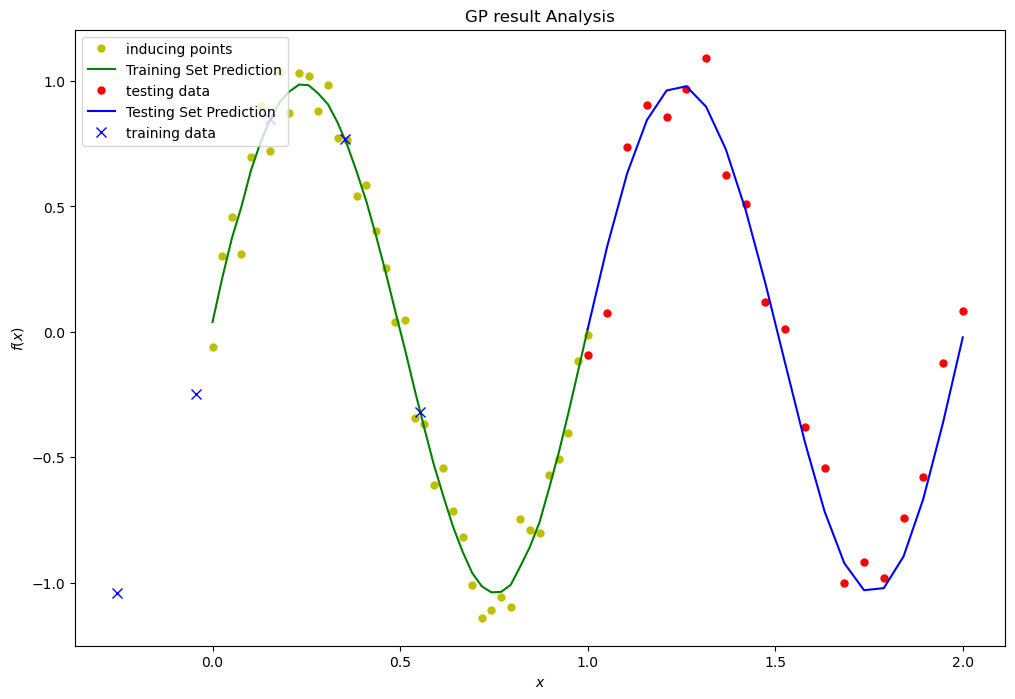

In [32]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(12,8))

#plot training data
plt.plot(X_train, Y_train, 'y.', markersize=10, label='inducing points')

# plot training prediction
# plt.plot(X_train, train_preds.mean, 'g-', label='Training Set Prediction')
plt.plot(X_train.sort().values, train_preds.mean[X_train.sort().indices], 'g-', label='Training Set Prediction')

#plot testing data
plt.plot(X_test, Y_test, 'r.', markersize=10, label='testing data')

#plot testing prediction
plt.plot(X_test, test_preds.mean, 'b-', label='Testing Set Prediction')

#plot original data
plt.plot(test_inducing, test_inducing_pred.mean, 'bx', markersize = 7, label = 'training data')

#add CI
# plt.fill_between(np.squeeze(X_test), (y_pred_test- ci).ravel(), (y_pred_test+ ci).ravel(), color='blue',alpha = 0.2)

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()